# SpatialData for Xenium

[SpatialData tutorials](spatialdata.scverse.org)  
[SpatialData github](https://github.com/scverse/spatialdata)  

---

In [1]:
import numpy as np
import pandas as pd
import os
import scanpy as sc
import squidpy as sq
import spatialdata as sd
import spatialdata_io as sdio
import spatialdata_plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
n_jobs=32
sc.settings.n_jobs=n_jobs

In [4]:
datadir='data'

---

## Reading and writing data

We can make an empty SpatialData object for illustration:

In [37]:
sdata_toy = sd.SpatialData()

As an example of a 'real' dataset, we use the Xenium Human Lymph Node 5K Preview dataset:

In [5]:
sdata = sdio.xenium(os.path.join(datadir, 'xenium_lymph_node_data'), n_jobs=n_jobs)

INFO     reading data/xenium_lymph_node_data/cell_feature_matrix.h5                                                
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


Experiment metadata:

In [6]:
file = open(os.path.join(datadir, 'xenium_lymph_node_data', 'experiment.xenium'))
experiment = json.load(file)
experiment

{'major_version': 5,
 'minor_version': 0,
 'patch_version': 0,
 'run_name': 'Human FFPE 5K Preview',
 'run_start_time': '2024-03-28T23:12:23Z',
 'region_name': 'Human Lymph Node Reactive (FFPE)',
 'preservation_method': 'FFPE',
 'num_cells': 708983,
 'transcripts_per_cell': 255,
 'transcripts_per_100um': 753.9842824927284,
 'region_area': 47977579.897187494,
 'total_cell_area': 25332686.295332965,
 'thickness_of_high_quality_decoded_transcripts': 5.046643647410482,
 'nuclear_transcripts_per_100um': 730.8167677264862,
 'fraction_transcripts_assigned': 0.9448485008998903,
 'segmented_cell_stain_frac': 0.9918305516493343,
 'segmented_cell_boundary_frac': 0.5683225126695562,
 'segmented_cell_interior_frac': 0.42350803897977807,
 'segmented_cell_nuc_expansion_frac': 0.008169448350665671,
 'imported_cell_frac': 0.0,
 'cassette_name': 'N/A',
 'slide_id': 'N/A',
 'panel_type': 'predesigned',
 'panel_design_id': 'N/A',
 'panel_predesigned_id': '',
 'panel_name': 'Xenium Human 5K Preview Panel',

Save as zarr:

In [8]:
sdata.write(os.path.join(datadir, 'lymph_node_data.zarr'), overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path: data/lymph_node_data.zarr            


In [9]:
sdata.path

PosixPath('data/lymph_node_data.zarr')

---

## SpatialData elements

### Images

Images can be 2D ('c', 'y', 'x') or 3D ('c', 'z', 'y', 'x'), with *c* denoting different channels. The images are stored as DataArray (single-scale) or DataTree (multi-scale).

In [10]:
sdata.images['morphology_focus']['scale0']['image']

<xarray.DataArray 'image' (c: 5, y: 34119, x: 39776)>
dask.array<rechunk-merge, shape=(5, 34119, 39776), dtype=uint16, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U22 'DAPI' 'ATP1A1/CD45/E-Cadherin' ... 'dummy'
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 3.412e+04 3.412e+04 3.412e+04
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 3.977e+04 3.977e+04 3.978e+04
Attributes:
    transform:  {'global': Identity }

Investigate image attributes like size and channel names:

In [11]:
sdata.images['morphology_focus']['scale0'].dims

Frozen({'c': 5, 'y': 34119, 'x': 39776})

In [12]:
sdata.images['morphology_focus']['scale0']['image']['c'].to_pandas()

c
DAPI                                        DAPI
ATP1A1/CD45/E-Cadherin    ATP1A1/CD45/E-Cadherin
18S                                          18S
AlphaSMA/Vimentin              AlphaSMA/Vimentin
dummy                                      dummy
dtype: object

### Labels

Cells and nuclei segmentation masks in 2D ('y', 'x')  or 3D ('z', 'y', 'x'), read from 'cells.zarr'. The cell_id column in the cell_labels_table must match the cell_id column from the cell labels data.

In [13]:
sdata.labels['cell_labels']['scale0'].image

<xarray.DataArray 'image' (y: 34119, x: 39776)>
dask.array<rechunk-merge, shape=(34119, 39776), dtype=uint32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 3.412e+04 3.412e+04 3.412e+04
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 3.977e+04 3.977e+04 3.978e+04
Attributes:
    transform:  {'global': Identity }

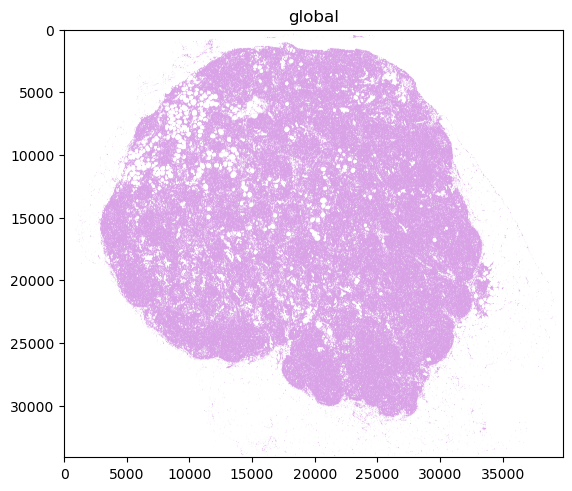

In [14]:
sdata.pl.render_labels('nucleus_labels').pl.show()

### Points

Dask dataframe with 2D ('y', 'x') or 3D ('z', 'y', 'x') coordinates and additional columns for e.g. feature names.

In [38]:
from spatialdata.models import PointsModel
coords = np.array([[1, 1], [2, 3], [4, 5]])
annotation = pd.DataFrame({"gene_id": ["gene_a", "gene_a", "gene_b"]})
annotation["gene_id"] = annotation["gene_id"].astype("category")
sdata_toy.points['mypoints'] =  PointsModel.parse(coords, annotation=annotation)

In [16]:
sdata.points['transcripts']['x'].min().compute() # compute min x

5.65625

### Shapes

GeoDataFrames with geometric objects (shapes) including Polygon, MultiPolygon and Point from shapely  

INFO     Using matplotlib                                                                                          


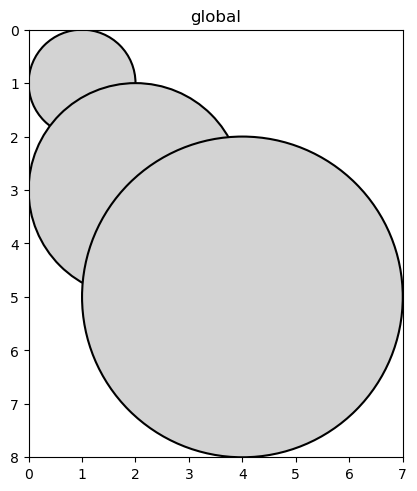

In [39]:
from spatialdata.models import ShapesModel
coords = np.array([[1, 1], [2, 3], [4, 5]])
radii = np.array([1, 2, 3])
sdata_toy.shapes['mycircles'] = ShapesModel.parse(coords, geometry=0, radius=radii)
sdata_toy.pl.render_shapes('mycircles', outline=True).pl.show()

### Tables

Anndata objects

In [23]:
from spatialdata.models import TableModel
from numpy.random import default_rng
from anndata import AnnData

We can add an adata object that does not annotate any spatial elements:

In [40]:
adata = AnnData(default_rng(seed=0).random((10, 8)))
sdata_toy.tables['no_elements'] = TableModel.parse(adata)

We can add an adata object that annotates a particular spatial element (in this case, *mycircles*):

In [68]:
adata = AnnData(default_rng(seed=0).random((len(sdata_toy['mycircles'].index), 8)))
adata.obs['myregion'] = 'mycircles' # sdata.shape element that is referenced (e.g. cells)
adata.obs['myregion'].astype("category")
adata.obs['circle_id'] = sdata_toy['mycircles'].index # individual element entry that is referenced( e.g. cell id)
sdata_toy.tables['one_element'] = TableModel.parse(adata, region='mycircles', region_key='myregion', instance_key='circle_id')

INFO     Using matplotlib                                                                                          


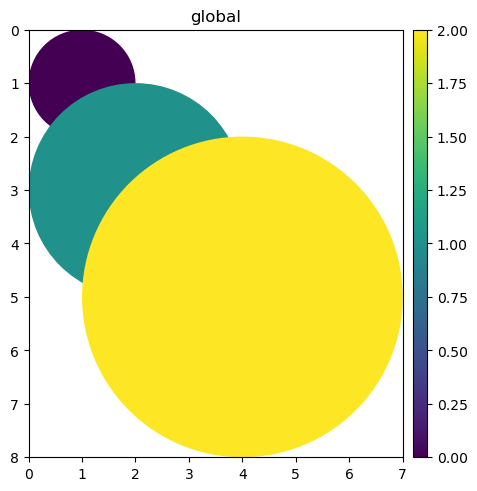

In [69]:
# now we can color the shapes element by columns from the adata object
sdata_toy.pl.render_shapes('mycircles', table_name='one_element', color='circle_id').pl.show()

Here, *.uns['spatialdata_attrs']* will be added to the table:

In [70]:
region = sdata_toy['one_element'].uns['spatialdata_attrs']['region'] # Elements that are annotated
region_key = sdata_toy['one_element'].uns['spatialdata_attrs']['region_key'] # Key in adata.obs that specifies the region
instance_key = sdata_toy['one_element'].uns['spatialdata_attrs']['instance_key'] # Key in adata.obs that specifies the instance

In [71]:
sdata_toy['one_element'].obs[region_key] # mycircles
sdata_toy['one_element'].obs.reset_index()[instance_key] # id of each circle
sdata_toy[region]

geometry  radius
0  POINT (1 1)       1
1  POINT (2 3)       2
2  POINT (4 5)       3

Finally, we can add an adata object that annotates multiple spatial elements (in this case, *mycircles* and *mycircles1*):

In [72]:
adata2 = adata.copy()
sdata_toy.shapes['mycircles1'] = ShapesModel.parse(coords, geometry=0, radius=radii) # add another shape
adata2.obs['myregion'] = adata2.obs['myregion'].cat.add_categories(['mycircles1'])
adata2.obs.iat[0, 0] = 'mycircles1'

In [73]:
del adata2.uns['spatialdata_attrs']
sdata_toy.tables['two_elements'] = TableModel.parse(adata2, region=['mycircles', 'mycircles1'], region_key='myregion', instance_key='circle_id')
sdata_toy.tables['two_elements'].uns['spatialdata_attrs']

{'region': ['mycircles', 'mycircles1'],
 'region_key': 'myregion',
 'instance_key': 'circle_id'}

The Xenium lymph node dataset already contains a table that annotates cells:

In [26]:
region_key = sdata['table'].uns['spatialdata_attrs']['region_key']
instance_key = sdata['table'].uns['spatialdata_attrs']['instance_key']
sdata['table'].obs[[region_key, instance_key]]
# sd.SpatialData.get_region_key_column(sdata['table'])
# sd.SpatialData.get_instance_key_column(sdata['table'])

region     cell_id
0       cell_circles  aaaaadoa-1
1       cell_circles  aaaaclhf-1
2       cell_circles  aaaafcfj-1
3       cell_circles  aaaagamp-1
4       cell_circles  aaaaiako-1
...              ...         ...
708978  cell_circles  oikoinno-1
708979  cell_circles  oikojopg-1
708980  cell_circles  oikokaeg-1
708981  cell_circles  oikooakd-1
708982  cell_circles  oikoolfj-1

[708983 rows x 2 columns]

Instead of using the *cells x counts* table from above, transcript counts can also be calculated for any other shape or label and be stored in a new adata object:

In [ ]:
sdata_nuclei = sd.aggregate(values=sdata['transcripts'], by=sdata['nucleus_boundaries'], value_key='feature_name', table_name='table_nuclei')

In [ ]:
sdata_nuclei

### Coordinate Systems

In [7]:
from spatialdata.transformations import *

In [8]:
sdata.coordinate_systems

['global']

The H&E image already has a transformation set, because the original H&E image had to be rotated to align with the Xenium images:

In [9]:
get_transformation(sdata['he_image'], to_coordinate_system='global')

Affine (x, y -> x, y)
    [6.64013400e-03 1.28916582e+00 3.11278649e+02]
    [-1.28916582e+00  6.64013400e-03  3.74328594e+04]
    [0. 0. 1.]

In [10]:
pixel_size = experiment['pixel_size']
scale_px_to_µm = Scale([pixel_size, pixel_size], axes=('x','y'))
scale_µm_to_px = Scale([1/pixel_size, 1/pixel_size], axes=('x','y'))
set_transformation(sdata['morphology_focus'], transformation=scale_px_to_µm, to_coordinate_system='global_µm')
set_transformation(sdata['cell_circles'], transformation=Identity(), to_coordinate_system='global_µm')
set_transformation(sdata['cell_boundaries'], transformation=Identity(), to_coordinate_system='global_µm')
set_transformation(sdata['cell_circles'], transformation=scale_µm_to_px, to_coordinate_system='global')
set_transformation(sdata['cell_boundaries'], transformation=scale_µm_to_px, to_coordinate_system='global')

In [11]:
transformation=Sequence([get_transformation(sdata['he_image'], to_coordinate_system='global'), scale_px_to_µm])
set_transformation(sdata['he_image'], transformation=transformation, to_coordinate_system='global_µm')

---

## Plotting

INFO     Using datashader                                                                                          


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5518031526336027].


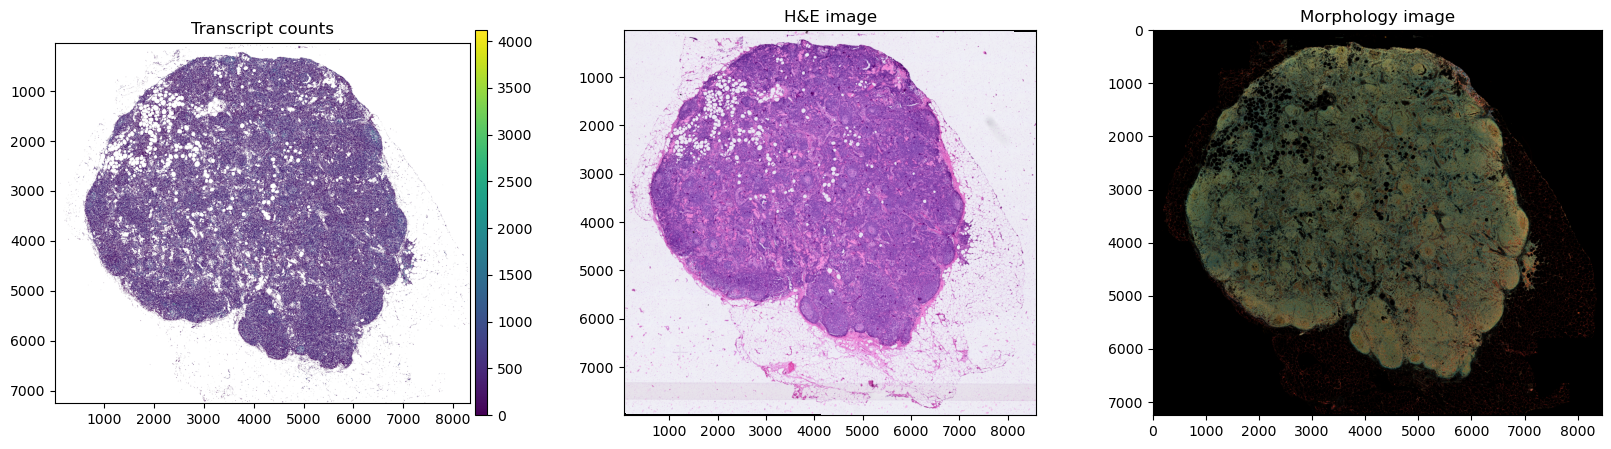

In [12]:
axes = plt.subplots(1, 3, figsize=(20, 5))[1].flatten()
sdata.pl.render_shapes('cell_circles', color='transcript_counts').pl.show(title='Transcript counts', coordinate_systems='global_µm', ax=axes[0])
sdata.pl.render_images('he_image').pl.show(title='H&E image', coordinate_systems='global_µm', ax=axes[1])
sdata.pl.render_images('morphology_focus').pl.show(title='Morphology image', coordinate_systems='global_µm', ax=axes[2])

Zoom into a region of interest (ROI):

In [13]:
from spatialdata import bounding_box_query 
ROI1 = lambda x: bounding_box_query(
    x,
    min_coordinate=[3800, 2900],
    max_coordinate=[4100, 3100],
    axes=("x", "y"),
    target_coordinate_system='global_µm',
)

In order to color  *cell_boundaries* by a column from an *adata.obs* table, the region annotation of the table needs to be changed:

In [12]:
sdata.tables['table'].obs['region'] = 'cell_boundaries'
sdata.set_table_annotates_spatialelement('table', region='cell_boundaries')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7039907727797001].


INFO     Using matplotlib                                                                                          


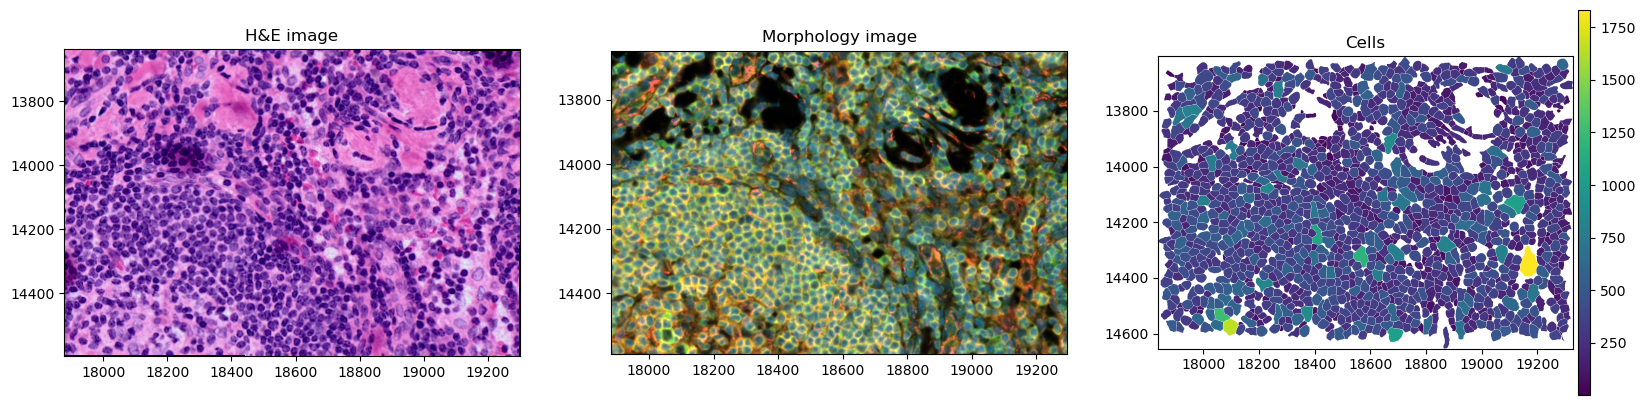

In [15]:
axes = plt.subplots(1, 3, figsize=(20, 5))[1].flatten()
ROI1(sdata).pl.render_images('he_image').pl.show(ax=axes[0], title='H&E image', coordinate_systems='global')
ROI1(sdata).pl.render_images('morphology_focus').pl.show(ax=axes[1], title='Morphology image', coordinate_systems='global')
ROI1(sdata).pl.render_shapes('cell_boundaries', color='transcript_counts').pl.show(ax=axes[2], title='Cells', coordinate_systems='global')

Elements can also be overlayed:

INFO     Using matplotlib                                                                                          


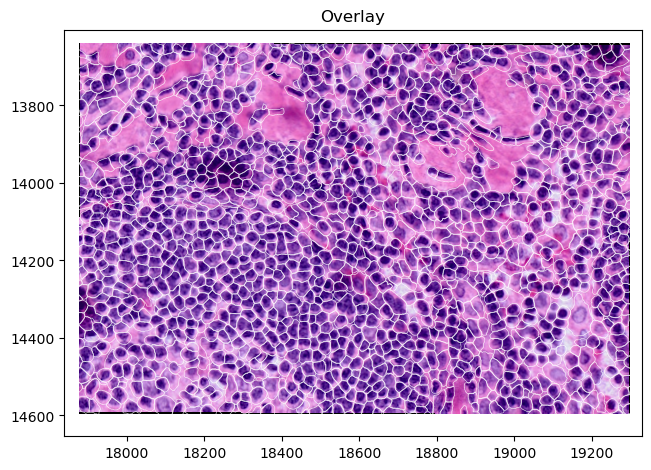

In [16]:
ROI1(sdata).pl.render_images('he_image').pl.render_shapes('cell_boundaries', fill_alpha=0, outline=True, outline_width=0.5, outline_color='#ffffff', outline_alpha=0.8).pl.show(title="Overlay", coordinate_systems="global")

---

## Subsetting and merging

### Subset by shape

In [16]:
from geopandas import GeoDataFrame
from shapely import Polygon
from spatialdata.models import ShapesModel

In [17]:
def get_roi_polygon(xmin, xmax, ymin, ymax):
    ROI = Polygon(((xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)))
    return ROI

Let's check how subsetting is done on the toy data. First we define the region we want to subset:

In [76]:
ROI = get_roi_polygon(xmin=0, xmax=2, ymin=0, ymax=2)
sdata_toy.shapes['ROI'] = ShapesModel.parse(GeoDataFrame({"geometry": [ROI] }))

INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          


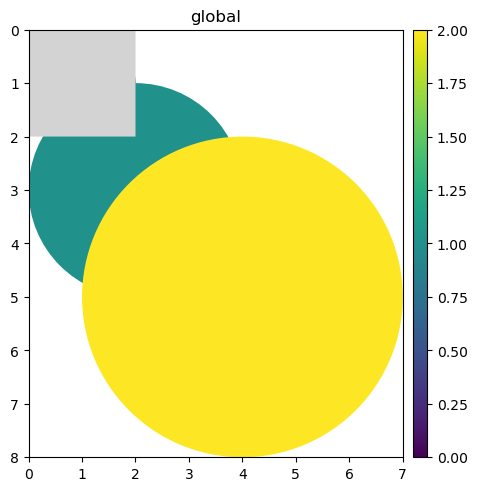

In [79]:
sdata_toy.pl.render_shapes('mycircles', table_name='one_element', color='circle_id').pl.render_shapes('ROI').pl.show()

This keeps all elements that at least partially overlap with the query region (ROI):

INFO     Using matplotlib                                                                                          


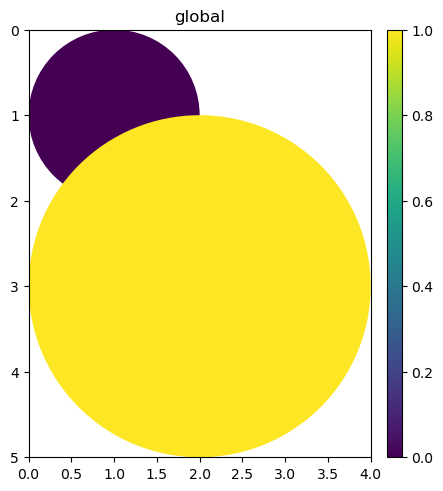

In [80]:
del sdata_toy['no_elements']
sdata_toy_sub = sd.polygon_query(sdata_toy, polygon=ROI, target_coordinate_system='global')
sdata_toy_sub.pl.render_shapes('mycircles', table_name='one_element', color='circle_id').pl.show()

In [81]:
sdata_toy_sub['one_element'].obs
sdata_toy_sub['two_elements'].obs

myregion  circle_id
0  mycircles1          0
1   mycircles          1

Now let's subset the lymph node data:

In [18]:
ROI = get_roi_polygon(xmin=18000, xmax=20000, ymin=19000, ymax=20000)
sdata.shapes['ROI'] = ShapesModel.parse(GeoDataFrame({'geometry': [ROI] }))

In [19]:
sdata_sub = sd.polygon_query(sdata, polygon=ROI, target_coordinate_system='global')

In [20]:
[sdata['table'].n_obs, sdata_sub['table'].n_obs] # cells before and after subsetting

[708983, 2135]

### Subset by annotation

In this example, let's retain only cells with high transcript counts:

In [113]:
sdata.tables['filtered'] = sdata['table'][ sdata['table'].obs['transcript_counts'] > 300 ]

In [114]:
sdata.tables['filtered'].obs['region'] = 'cell_circles'
sdata.set_table_annotates_spatialelement('filtered', region='cell_circles')
sdata.tables['filtered'].uns['spatialdata_attrs']

{'region': 'cell_circles', 'region_key': 'region', 'instance_key': 'cell_id'}

In [115]:
sdata['filtered'].obs[['region', 'cell_id']]

region     cell_id
1       cell_circles  aaaaclhf-1
2       cell_circles  aaaafcfj-1
7       cell_circles  aaaanoim-1
10      cell_circles  aaabaejn-1
12      cell_circles  aaabeaec-1
...              ...         ...
708799  cell_circles  oijpccmg-1
708806  cell_circles  oijpjibe-1
708854  cell_circles  oikdhpef-1
708947  cell_circles  oikmgfoe-1
708950  cell_circles  oikmgpjf-1

[262269 rows x 2 columns]

INFO     Using datashader                                                                                          
INFO     Using datashader                                                                                          


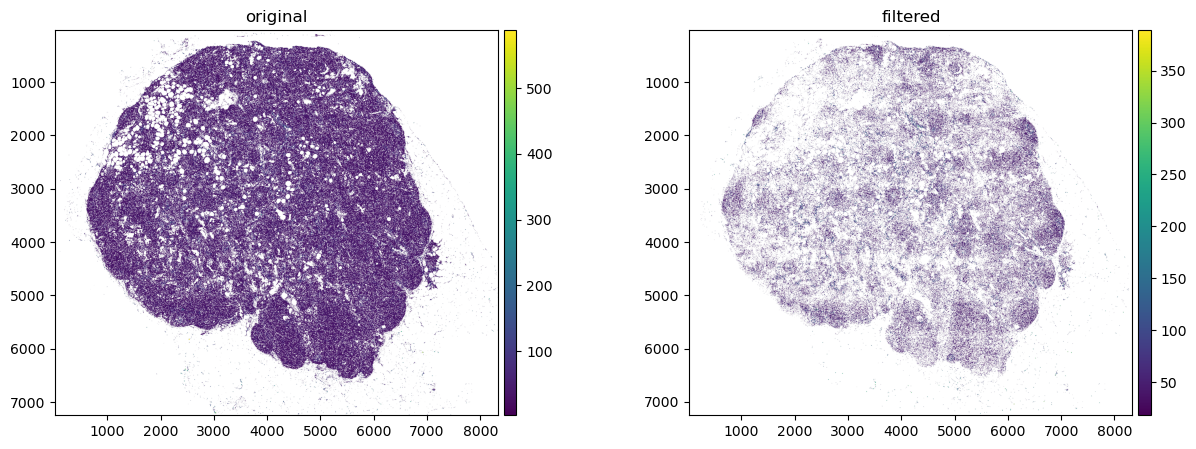

In [120]:
axes = plt.subplots(1, 2, figsize=(15, 5))[1].flatten()
sdata.pl.render_shapes('cell_boundaries', color='cell_area', table_name='table').pl.show(title='original', coordinate_systems='global_µm', ax=axes[0])
sdata.pl.render_shapes('cell_circles', color='cell_area', table_name='filtered').pl.show(title='filtered', coordinate_systems='global_µm', ax=axes[1])

### Merging

First we generate some ROI subsets that can be used for merging:

In [22]:
del sdata.tables['filtered']
ROI1 = get_roi_polygon(xmin=18000, xmax=20000, ymin=19000, ymax=20000)
ROI2 = get_roi_polygon(xmin=20000, xmax=22000, ymin=19000, ymax=20000)
sdata_roi1 = sd.polygon_query(sdata, polygon=ROI1, target_coordinate_system='global')
sdata_roi2 = sd.polygon_query(sdata, polygon=ROI2, target_coordinate_system='global')

In [23]:
sdata_roi1['table'].obs['subset'] = 'ROI1'
sdata_roi2['table'].obs['subset'] = 'ROI2'

Because elements that can not be merged (images, labels, points) must have unique names, we have to rename or remove them before concatenation:

In [24]:
sdata_roi1['he_image_roi1'] = sdata_roi1['he_image'].copy()
sdata_roi1['cell_circles_roi1'] = sdata_roi1['cell_circles'].copy()
sdata_roi1 = sdata_roi1.subset(element_names = ['he_image_roi1', 'cell_circles_roi1', 'table']) 
sdata_roi2['he_image_roi2'] = sdata_roi2['he_image'].copy()
sdata_roi2['cell_circles_roi2'] = sdata_roi2['cell_circles'].copy()
sdata_roi2 = sdata_roi2.subset(element_names = ['he_image_roi2', 'cell_circles_roi2', 'table']) 

Also the spatial annotations of the tables need to be updated:

In [25]:
sdata_roi1.tables['table'].obs['region'] = 'cell_circles_roi1'
sdata_roi1.set_table_annotates_spatialelement('table', region='cell_circles_roi1')
sdata_roi2.tables['table'].obs['region'] = 'cell_circles_roi2'
sdata_roi2.set_table_annotates_spatialelement('table', region='cell_circles_roi2')

Now we can concatenate the data (this will merge tables of the same name) and merge the 'cell_circles' shapes to annotate all cells:

In [110]:
sdata_merged = sd.concatenate([sdata_roi1, sdata_roi2], concatenate_tables=True)
sdata_merged.shapes['cell_circles'] = pd.concat(sdata_merged.shapes)
sdata_merged.shapes['cell_circles'].index.names=['sample', 'cell_id']
sdata_merged.shapes['cell_circles'] = sdata_merged.shapes['cell_circles'].droplevel(0)
sdata_merged['table'].obs.set_index('cell_id', inplace=True, drop=False)
sdata_merged.tables['table'].obs['region'] = 'cell_circles'
sdata_merged.set_table_annotates_spatialelement('table', region='cell_circles')

However we still have to remove some duplicated cells that were present in both ROIs:

In [111]:
sdata_merged.tables['table'] = sdata_merged.tables['table'][~sdata_merged.tables['table'].obs.index.duplicated(keep='first')]
sdata_merged.shapes['cell_circles'] = sdata_merged.shapes['cell_circles'][~sdata_merged.shapes['cell_circles'].index.duplicated(keep='first')]
ix = sdata_merged.tables['table'].obs.index.intersection(sdata_merged.shapes['cell_circles'].index).drop_duplicates()
sdata_merged.shapes['cell_circles'] = sdata_merged.shapes['cell_circles'].loc[ix]
sdata_merged.tables['table'] = sdata_merged.tables['table'][ix]
sd.match_table_to_element(sdata_merged, 'cell_circles', table_name='table')

AnnData object with n_obs × n_vars = 4331 × 4624
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'subset'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

INFO     Using matplotlib                                                                                          


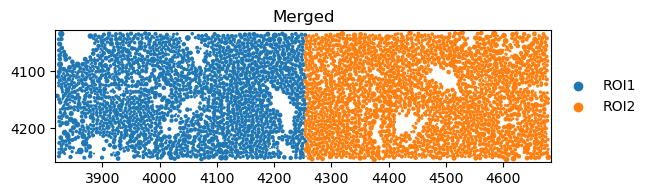

In [112]:
sdata_merged.pl.render_shapes('cell_circles', color='subset').pl.show(title='Merged', coordinate_systems='global_µm')